# Fingerprint-based similarity scores - average number of bits


Compare multiple fingerprints on the **ms2structures** dataset (37,811 compounds)

In [ ]:
import os
import sys
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

ROOT = Path(os.getcwd()).parents[0]
path_data = os.path.join(Path(ROOT), "data")

In [2]:
filename = "compounds_ms2structures.csv"
compounds = pd.read_csv(os.path.join(path_data, filename))
compounds.head()

,inchikey,smiles,mass,cf_class,cf_subclass,cf_superclass,formula,npc_class_results,npc_pathway_results,npc_superclass_results
0,AAAQFGUYHFJNHI,CCNC(=O)C[C@H]1C2=NN=C(N2C3=C(C=C(C=C3)OC)C(=N...,423.146204,Benzodiazepines,"1,4-benzodiazepines",Organoheterocyclic compounds,C22H22ClN5O2,NaN,Alkaloids,NaN
1,AABFWJDLCCDJJN,COC1=CC2=C(C=C1)NC3=C2C=CN=C3C4=CC=CC5=CC=CC=C54,324.126264,Harmala alkaloids,NaN,Alkaloids and derivatives,C22H16N2O,Carboline alkaloids,Alkaloids,Tryptophan alkaloids
2,AABILZKQMVKFHP,C/C=C(/C)\C(=O)O[C@H]1CC[N+]2([C@@H]1C(=CC2)CO...,427.220624,NaN,NaN,Alkaloids and derivatives,C21H33NO8,Pyrrolizidine alkaloids,Alkaloids,Ornithine alkaloids
3,AABUHSBGEIUSRJ,CC(=O)NC1=CC=C(C=C1)NC(=O)C=CC2=CC=CC=C2,280.120724,Cinnamic acids and derivatives,Cinnamic acid amides,Phenylpropanoids and polyketides,C17H16N2O2,Cinnamic acid amides,Shikimates and Phenylpropanoids,Phenylpropanoids (C6-C3)
4,AABUKWVVUWBZCS,C1=CC=C(C=C1)C2=C(C(=O)OC3=C2C=CC(=C3)O)C4=CC=...,314.094724,Neoflavonoids,Neoflavones,Phenylpropanoids and polyketides,C21H14O3,Neoflavonoids,Shikimates and Phenylpropanoids,Flavonoids


In [3]:
compounds.shape

(37811, 10)

## Compute percentile scores and compare

In [ ]:
# Add source code path
sys.path.insert(0, os.path.join(ROOT, "src"))

# Import funtion/classes from source code
from fingerprint_computation import compute_fingerprints_from_smiles

In [ ]:
from typing import List
from rdkit.Chem import Mol
from map4 import MAP4
#from mbp import MBP
#from map4neo import MAP4neo

def compute_map_fingerprints_from_smiles(smiles, map_generator):
    
    molecules: List[Mol] = [Chem.MolFromSmiles(s) for s in smiles]
    fingerprints_map: np.ndarray = map_generator.calculate_many(
        molecules,
        number_of_threads=32,
        verbose=True,
    )
    return list(fingerprints_map)


def compute_sparse_map_fingerprints_from_smiles(
    smiles,
    map_generator,
    count=False,
    ):
    molecules: List[Mol] = [Chem.MolFromSmiles(s) for s in smiles]
    fingerprints_map: np.ndarray = map_generator.calculate_many_sparse(
        molecules,
        number_of_threads=32,
        verbose=True,
        count=count,
    )
    return list(fingerprints_map)


def compute_sparse_map_fingerprints_from_smiles_serial(
        smiles,
        map_generator,
        count=False
        ):

    molecules: List[Mol] = [Chem.MolFromSmiles(s) for s in smiles]
    fingerprints = []
    for mol in tqdm(molecules):
        if count:
            fp = map_generator.calculate_sparse(mol, count=count)
            fingerprints.append(fp)
        else:
            fp_bits = map_generator._calculate(mol)
            fingerprints.append(np.sort(map_generator.encoder.hash(fp_bits)))
    return fingerprints

In [ ]:
experiments = [
    #("morgan2_count", rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=4096), True),
    #("morgan3_count", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096), True),
    #("morgan9_count", rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096), True),
    #("morgan12_count", rdFingerprintGenerator.GetMorganGenerator(radius=12, fpSize=4096), True),
    ("morgan2_binary", rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=4096), False),
    ("morgan3_binary", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096), False),
    ("morgan9_binary", rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096), False),
    ("morgan12_binary", rdFingerprintGenerator.GetMorganGenerator(radius=12, fpSize=4096), False),
    ("rdkit", rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=4096), False),
    ("map2", MAP4(dimensions=4096, radius=1, include_duplicated_shingles=False), False),
    ("map4", MAP4(dimensions=4096, radius=2, include_duplicated_shingles=False), False),
    #("mbp2", MBP(dimensions=4096, radius=1), False),
    #("mbp2_binned", MBP(dimensions=4096, radius=1, dist_binning=np.array([0, 1, 2, 4, 8, 16, 32, 64])), False),
    #("mbp2_count", MBP(dimensions=4096, radius=1), True),
    #("mbp2_binned_count", MBP(dimensions=4096, radius=1, dist_binning=np.array([0, 1, 2, 4, 8, 16, 32, 64])), True),
    #("morgan2_count_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=4096), True),
    #("morgan3_count_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096), True),
    #("morgan9_count_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096), True),
    ("morgan2_binary_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=4096), False),
    ("morgan3_binary_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096), False),
    ("morgan9_binary_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096), False),
    ("morgan12_binary_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=12, fpSize=4096), False),
    #("morgan12_count_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=12, fpSize=4096), True),
    #("morgan3_logcount", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096), True),
    #("morgan9_logcount", rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096), True),
    #("morgan12_logcount", rdFingerprintGenerator.GetMorganGenerator(radius=12, fpSize=4096), True),
    #("morgan3_logcount_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096), True),
    #("morgan9_logcount_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096), True),
    #("morgan12_logcount_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=12, fpSize=4096), True),
    ("rdkit_sparse", rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=4096), False),
    ("map2_sparse", MAP4(dimensions=4096, radius=1, include_duplicated_shingles=False), False),
    ("map4_sparse", MAP4(dimensions=4096, radius=2, include_duplicated_shingles=False), False),
    #("mbp2_sparse", MBP(dimensions=4096, radius=1), False),
    #("mbp2_binned_sparse", MBP(dimensions=4096, radius=1, dist_binning=np.array([0, 1, 2, 4, 8, 16, 32, 64])), False),
    #("mbp2_count_sparse", MBP(dimensions=4096, radius=1), True),
    #("mbp2_binned_count_sparse", MBP(dimensions=4096, radius=1, dist_binning=np.array([0, 1, 2, 4, 8, 16, 32, 64])), True),
]

In [7]:
path_results = os.path.join(Path(ROOT), "experiments", "bit_counts")

In [ ]:
# collect all per-experiment stats
results_list = []
used_bits_collection = {}


for experiment in experiments:
    name, fpgen, count = experiment

    results_filepath = os.path.join(path_results, f"bit_statistics_summary_{name}.csv")
    if os.path.exists(results_filepath):
        print(f"----- Found existing results for experiment: {name} -----")
        print("----- (experiment will be skipped) -----")
        continue

    print(f"----- Experiment: {name} -----")

    if "_sparse" in name:
        if ("map" in name):
            fingerprints = compute_sparse_map_fingerprints_from_smiles_serial(compounds.smiles, fpgen)
        elif ("mbp" in name):
            if "count" in name:
                fingerprints = compute_sparse_map_fingerprints_from_smiles(compounds.smiles, fpgen, count=True)
            else:
                fingerprints = compute_sparse_map_fingerprints_from_smiles(compounds.smiles, fpgen)
        else:
            fingerprints = compute_fingerprints_from_smiles(
                compounds.smiles, fpgen, sparse=True,
                count=count, progress_bar=True
            )
        print(f"Collected {len(fingerprints)} sparse fingerprints.")
       
    else:
        if ("map" in name) or ("mbp" in name):
            fingerprints = compute_map_fingerprints_from_smiles(compounds.smiles, fpgen)
            fingerprints = np.stack(fingerprints)
        else:
            fingerprints = compute_fingerprints_from_smiles(
                compounds.smiles, fpgen, sparse=False,
                count=count, progress_bar=True
            )
            fingerprints = np.stack(fingerprints)
        print(f"Collected {fingerprints.shape[0]} fingerprints.")


    # -------- now compute summary statistics --------
    if isinstance(fingerprints[0], tuple):
        used_bits = np.array([len(fp[0]) for fp in fingerprints])
    elif isinstance(fingerprints, np.ndarray):
        used_bits = (fingerprints > 0).sum(axis=1)
    else:
        used_bits = np.array([len(fp) for fp in fingerprints])
    used_bits_collection[name] = used_bits

    # basic stats
    mean_bins   = used_bits.mean()
    median_bins = np.median(used_bits)
    std_bins    = used_bits.std()
    mad_bins   = np.median(np.abs(used_bits - median_bins))
    q1 = np.percentile(used_bits, 25)
    q3 = np.percentile(used_bits, 75)
    
    # pack into a dict
    result = {
        "experiment":       name,
        "mean_bins":  mean_bins,
        "median_bins": median_bins,
        "std_bins":   std_bins,
        "mad_bins":   mad_bins,
        "q1": q1,
        "q3": q3,
    }
    results_list.append(result)

    # save a per-experiment checkpoint
    chkpt_df = pd.DataFrame([result])
    chkpt_df.to_csv(results_filepath, index=False)
    pd.DataFrame([used_bits]).to_pickle(results_filepath.replace(".csv", ".pickle"))
    print(f"Saved checkpoint to {results_filepath}")

----- Experiment: morgan2_binary -----


100%|███████████████████████████████████| 37811/37811 [00:04<00:00, 7866.05it/s]


Collected 37811 fingerprints.
Saved checkpoint to /home/daisy/Florian/molecular_fingerprint_comparisons/experiments/bit_counts/bit_statistics_summary_morgan2_binary.csv
----- Experiment: morgan3_binary -----


100%|███████████████████████████████████| 37811/37811 [00:05<00:00, 6928.51it/s]


Collected 37811 fingerprints.
Saved checkpoint to /home/daisy/Florian/molecular_fingerprint_comparisons/experiments/bit_counts/bit_statistics_summary_morgan3_binary.csv
----- Experiment: morgan9_binary -----


100%|███████████████████████████████████| 37811/37811 [00:08<00:00, 4537.80it/s]


Collected 37811 fingerprints.
Saved checkpoint to /home/daisy/Florian/molecular_fingerprint_comparisons/experiments/bit_counts/bit_statistics_summary_morgan9_binary.csv
----- Experiment: morgan12_binary -----


100%|███████████████████████████████████| 37811/37811 [00:08<00:00, 4202.69it/s]


Collected 37811 fingerprints.
Saved checkpoint to /home/daisy/Florian/molecular_fingerprint_comparisons/experiments/bit_counts/bit_statistics_summary_morgan12_binary.csv
----- Experiment: rdkit -----


100%|████████████████████████████████████| 37811/37811 [00:37<00:00, 997.84it/s]


Collected 37811 fingerprints.
Saved checkpoint to /home/daisy/Florian/molecular_fingerprint_comparisons/experiments/bit_counts/bit_statistics_summary_rdkit.csv
----- Experiment: map2 -----


Calculating fingerprints:   0%|                       | 0/37811 [00:00<?, ?it/s]

Collected 37811 fingerprints.
Saved checkpoint to /home/daisy/Florian/molecular_fingerprint_comparisons/experiments/bit_counts/bit_statistics_summary_map2.csv
----- Experiment: map4 -----


Calculating fingerprints:   0%|                       | 0/37811 [00:00<?, ?it/s]

Collected 37811 fingerprints.
Saved checkpoint to /home/daisy/Florian/molecular_fingerprint_comparisons/experiments/bit_counts/bit_statistics_summary_map4.csv
----- Experiment: mbp2 -----
Collected 37811 fingerprints.
Saved checkpoint to /home/daisy/Florian/molecular_fingerprint_comparisons/experiments/bit_counts/bit_statistics_summary_mbp2.csv
----- Experiment: mbp2_binned -----
Collected 37811 fingerprints.
Saved checkpoint to /home/daisy/Florian/molecular_fingerprint_comparisons/experiments/bit_counts/bit_statistics_summary_mbp2_binned.csv
----- Experiment: morgan2_binary_sparse -----


100%|███████████████████████████████████| 37811/37811 [00:04<00:00, 8046.25it/s]


Collected 37811 sparse fingerprints.
Saved checkpoint to /home/daisy/Florian/molecular_fingerprint_comparisons/experiments/bit_counts/bit_statistics_summary_morgan2_binary_sparse.csv
----- Experiment: morgan3_binary_sparse -----


100%|███████████████████████████████████| 37811/37811 [00:05<00:00, 6808.73it/s]


Collected 37811 sparse fingerprints.
Saved checkpoint to /home/daisy/Florian/molecular_fingerprint_comparisons/experiments/bit_counts/bit_statistics_summary_morgan3_binary_sparse.csv
----- Experiment: morgan9_binary_sparse -----


100%|███████████████████████████████████| 37811/37811 [00:08<00:00, 4381.43it/s]


Collected 37811 sparse fingerprints.
Saved checkpoint to /home/daisy/Florian/molecular_fingerprint_comparisons/experiments/bit_counts/bit_statistics_summary_morgan9_binary_sparse.csv
----- Experiment: morgan12_binary_sparse -----


100%|███████████████████████████████████| 37811/37811 [00:09<00:00, 4063.15it/s]


Collected 37811 sparse fingerprints.
Saved checkpoint to /home/daisy/Florian/molecular_fingerprint_comparisons/experiments/bit_counts/bit_statistics_summary_morgan12_binary_sparse.csv
----- Experiment: rdkit_sparse -----


100%|████████████████████████████████████| 37811/37811 [00:45<00:00, 837.60it/s]


Collected 37811 sparse fingerprints.
Saved checkpoint to /home/daisy/Florian/molecular_fingerprint_comparisons/experiments/bit_counts/bit_statistics_summary_rdkit_sparse.csv
----- Experiment: map2_sparse -----


  0%|          | 0/37811 [00:00<?, ?it/s]

Collected 37811 sparse fingerprints.
Saved checkpoint to /home/daisy/Florian/molecular_fingerprint_comparisons/experiments/bit_counts/bit_statistics_summary_map2_sparse.csv
----- Experiment: map4_sparse -----


  0%|          | 0/37811 [00:00<?, ?it/s]

Collected 37811 sparse fingerprints.
Saved checkpoint to /home/daisy/Florian/molecular_fingerprint_comparisons/experiments/bit_counts/bit_statistics_summary_map4_sparse.csv
----- Experiment: mbp2_sparse -----


Calculating sparse fingerprints:   0%|          | 0/37811 [00:00<?, ?it/s]

Collected 37811 sparse fingerprints.
Saved checkpoint to /home/daisy/Florian/molecular_fingerprint_comparisons/experiments/bit_counts/bit_statistics_summary_mbp2_sparse.csv
----- Experiment: mbp2_binned_sparse -----


Calculating sparse fingerprints:   0%|          | 0/37811 [00:00<?, ?it/s]

Collected 37811 sparse fingerprints.
Saved checkpoint to /home/daisy/Florian/molecular_fingerprint_comparisons/experiments/bit_counts/bit_statistics_summary_mbp2_binned_sparse.csv


In [48]:
(fingerprints > 0).sum(axis=1).shape

(37811,)

In [50]:
import glob

csv_pattern = os.path.join(path_results, "bit_statistics_summary_*.csv")
all_files = glob.glob(csv_pattern)

# collect DataFrames here
df_list = []

for fp in all_files:
    df = pd.read_csv(fp)

    df_list.append(df)

combined_df = pd.concat(df_list, ignore_index=True)

In [52]:
combined_df.sort_values("mean_bins")

,experiment,mean_bins,median_bins,std_bins,mad_bins,q1,q3
12,morgan2_count,47.117426,47.0,16.394807,10.0,36.0,56.0
34,morgan2_binary,47.117426,47.0,16.394807,10.0,36.0,56.0
17,morgan2_count_sparse,47.351035,47.0,16.604139,10.0,37.0,56.0
15,morgan2_binary_sparse,47.351035,47.0,16.604139,10.0,37.0,56.0
25,morgan3_logcount,64.993388,64.0,24.277447,14.0,50.0,78.0
13,morgan3_count,64.993388,64.0,24.277447,14.0,50.0,78.0
32,morgan3_binary,64.993388,64.0,24.277447,14.0,50.0,78.0
23,morgan3_count_sparse,65.486155,64.0,24.714581,14.0,50.0,79.0
2,morgan3_logcount_sparse,65.486155,64.0,24.714581,14.0,50.0,79.0
0,morgan3_binary_sparse,65.486155,64.0,24.714581,14.0,50.0,79.0


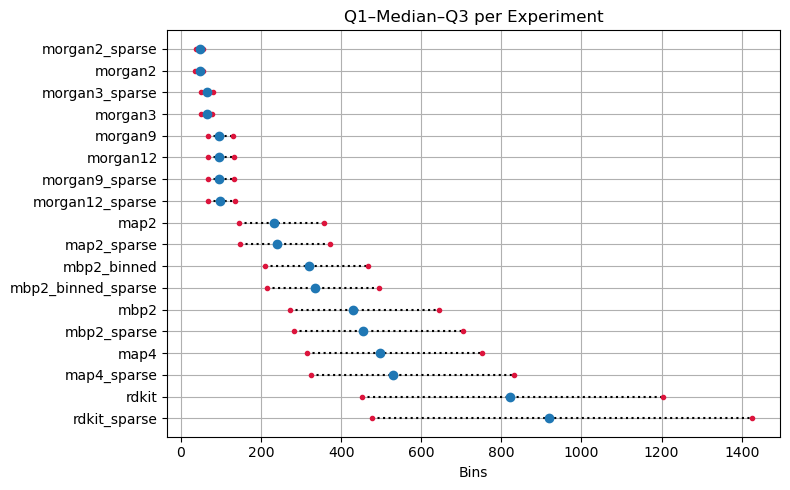

In [64]:
df = combined_df.copy()

# strip off the '_count', '_binary', '_logcount' suffixes
df['exp_base'] = df['experiment'].str.replace(r'_(count|binary|logcount)', '', regex=True)

# drop duplicates, keeping the first occurrence per base name
df_unique = df.drop_duplicates(subset='exp_base').reset_index(drop=True).sort_values("median_bins")

# plotting
fig, ax = plt.subplots(figsize=(8, 5))

y = range(len(df_unique))
ax.hlines(
    y=y, xmin=df_unique['q1'], xmax=df_unique['q3'], 
    linestyle=":", color="black"
)
ax.plot(df_unique['q1'], y, marker='.', linestyle='', color="crimson")
ax.plot(df_unique['q3'], y, marker='.', linestyle='', color="crimson")
ax.plot(df_unique['median_bins'], y, marker='o', linestyle='')


ax.set_yticks(y)
ax.set_yticklabels(df_unique['exp_base'])
ax.set_xlabel('Bins')
ax.set_title('Q1–Median–Q3 per Experiment')
ax.invert_yaxis()  # so the first experiment is at the top
plt.grid(True)
plt.tight_layout()
plt.show()


In [68]:
import glob

csv_pattern = os.path.join(path_results, "bit_statistics_summary_*.pickle")
all_files = glob.glob(csv_pattern)

# collect DataFrames here
df_list = []

for fp in all_files:
    df = pd.read_pickle(fp)

    df_list.append(df)


In [72]:
df.columns

Index(['morgan2_binary', 'morgan3_binary', 'morgan9_binary', 'morgan12_binary',
       'rdkit', 'map2', 'map4', 'mbp2', 'mbp2_binned', 'morgan2_binary_sparse',
       'morgan3_binary_sparse', 'morgan9_binary_sparse',
       'morgan12_binary_sparse', 'rdkit_sparse', 'map2_sparse', 'map4_sparse'],
      dtype='object')

In [75]:
df.morgan2_binary.values

array([array([59, 43, 61, ..., 35, 57, 66])], dtype=object)

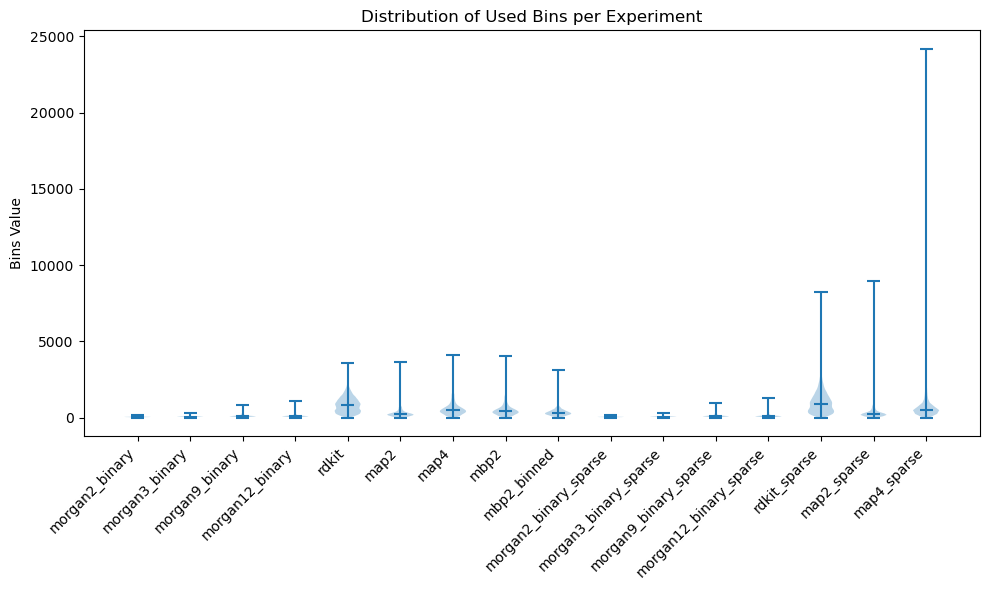

In [78]:
import matplotlib.pyplot as plt

# Assume df exists where each column is an array of bin values

data = [df[col].values[0] for col in df.columns]
labels = df.columns.tolist()

fig, ax = plt.subplots(figsize=(10, 6))
# Create violin plot
vp = ax.violinplot(data, showmedians=True)

# Set x-ticks and labels
ax.set_xticks(range(1, len(labels) + 1))
ax.set_xticklabels(labels, rotation=45, ha='right')

ax.set_ylabel('Bins Value')
ax.set_title('Distribution of Used Bins per Experiment')
plt.tight_layout()
plt.show()


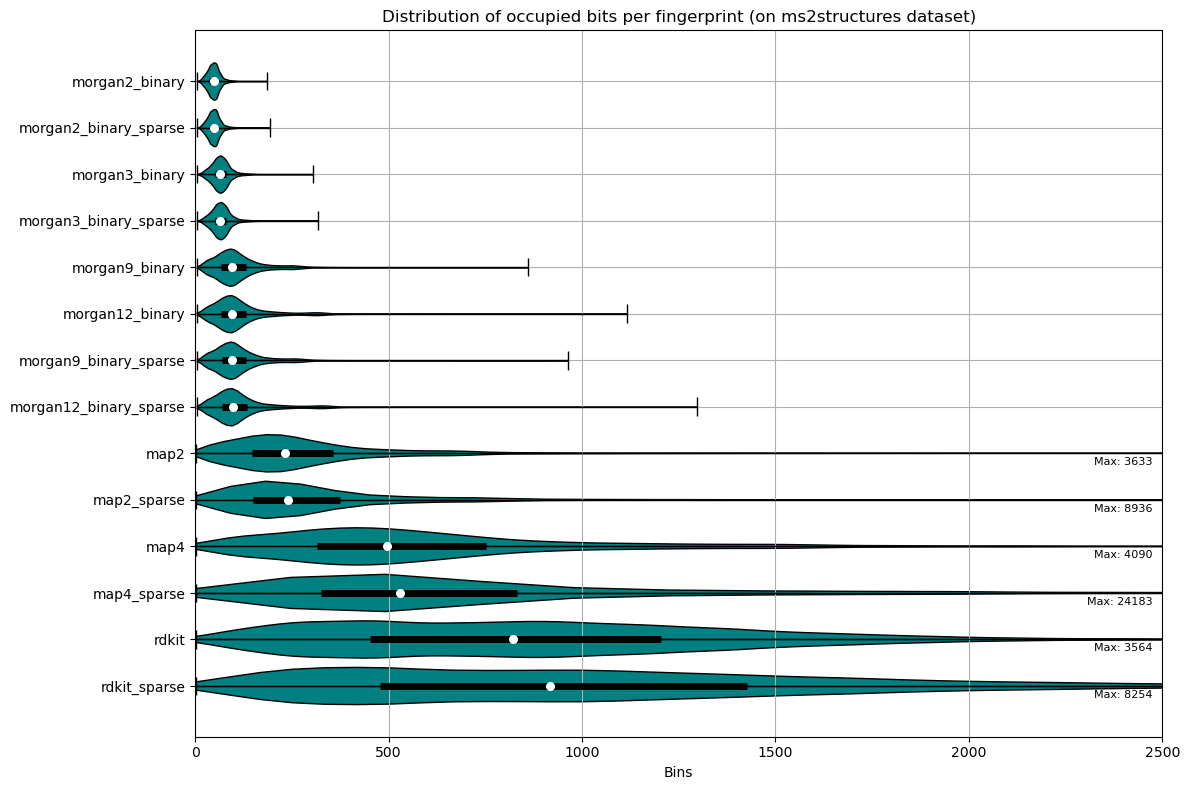

In [127]:
xmax = 2500


# Collect your data and labels
#labels = [x for x in df.columns.tolist()]
labels = [x for x in df.columns.tolist() if "mbp" not in x]
data = [df[col].values[0] for col in labels]

# 2. helper to compute adjacent whisker values
def adjacent_values(sorted_array, q1, q3):
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr
    upper_adj = sorted_array[sorted_array <= upper].max()
    lower_adj = sorted_array[sorted_array >= lower].min()
    return lower_adj, upper_adj

# 3. compute quartiles & whiskers
quartile1, medians, quartile3 = [], [], []
whiskers_min, whiskers_max = [], []
max_values = []

for arr in data:
    sorted_arr = np.sort(arr)
    q1, med, q3 = np.percentile(sorted_arr, [25, 50, 75])
    low, high = adjacent_values(sorted_arr, q1, q3)
    quartile1.append(q1)
    medians.append(med)
    quartile3.append(q3)
    whiskers_min.append(low)
    whiskers_max.append(high)
    max_values.append(sorted_arr.max())

quartile1 = np.array(quartile1)
medians   = np.array(medians)
quartile3 = np.array(quartile3)
whiskers_min = np.array(whiskers_min)
whiskers_max = np.array(whiskers_max)
max_values = np.array(max_values)

# 4. sort everything by the median
order = np.argsort(medians)
labels_sorted    = [labels[i]    for i in order]
data_sorted      = [data[i]      for i in order]
q1_sorted        = quartile1[order]
med_sorted       = medians[order]
q3_sorted        = quartile3[order]
wh_min_sorted    = whiskers_min[order]
wh_max_sorted    = whiskers_max[order]
max_values_sorted= max_values[order]

# 5. plot
fig, ax = plt.subplots(figsize=(12, 8))

# horizontal violins, suppress default extrema
vp = ax.violinplot(
    data_sorted,
    vert=False,
    widths=0.8,
    showmedians=False,
    #showextrema=False
)

for pc in vp['bodies']:
    pc.set_facecolor('teal')
    pc.set_edgecolor('black')
    #pc.set_color('black')
    pc.set_alpha(1)

# positions
inds = np.arange(1, len(labels_sorted) + 1)

# color the extrema lines
for part in ('cmaxes', 'cmins', 'cbars'):
    lc = vp[part]
    lc.set_color('black')
    lc.set_linewidth(1)

# draw custom “stems”
ax.scatter(med_sorted, inds, marker='o', color='white', s=30, zorder=3)
ax.hlines(inds, q1_sorted, q3_sorted, color='k', linestyle='-', lw=5)
ax.hlines(inds, wh_min_sorted, wh_max_sorted, color='k', linestyle='-', lw=1)

# labels & styling
ax.set_yticks(inds)
ax.set_yticklabels(labels_sorted)
ax.set_xlabel('Bins')
ax.set_title('Distribution of occupied bits per fingerprint (on ms2structures dataset)')
ax.invert_yaxis()  # highest median at top

ax.set_xlim(0, xmax)

# annotate any whisker‐maxima outside the frame
for idx, wmax in enumerate(max_values_sorted):
    if wmax > xmax:
        # y-pos of this violin is idx+1 (since inds = 1…N)
        y = idx + 1
        # place the text just inside the right edge, slightly above the center line
        ax.text(
            xmax * 0.99,    # 99% of your x-axis
            y + 0.3,        # tiny nudge above
            f"Max: {int(wmax)}", # show integer value
            ha='right', va='bottom', fontsize=8
        )

plt.grid(True)
plt.tight_layout()

#plt.savefig("fig_bit_occupation_violin.png", dpi=450)
plt.show()

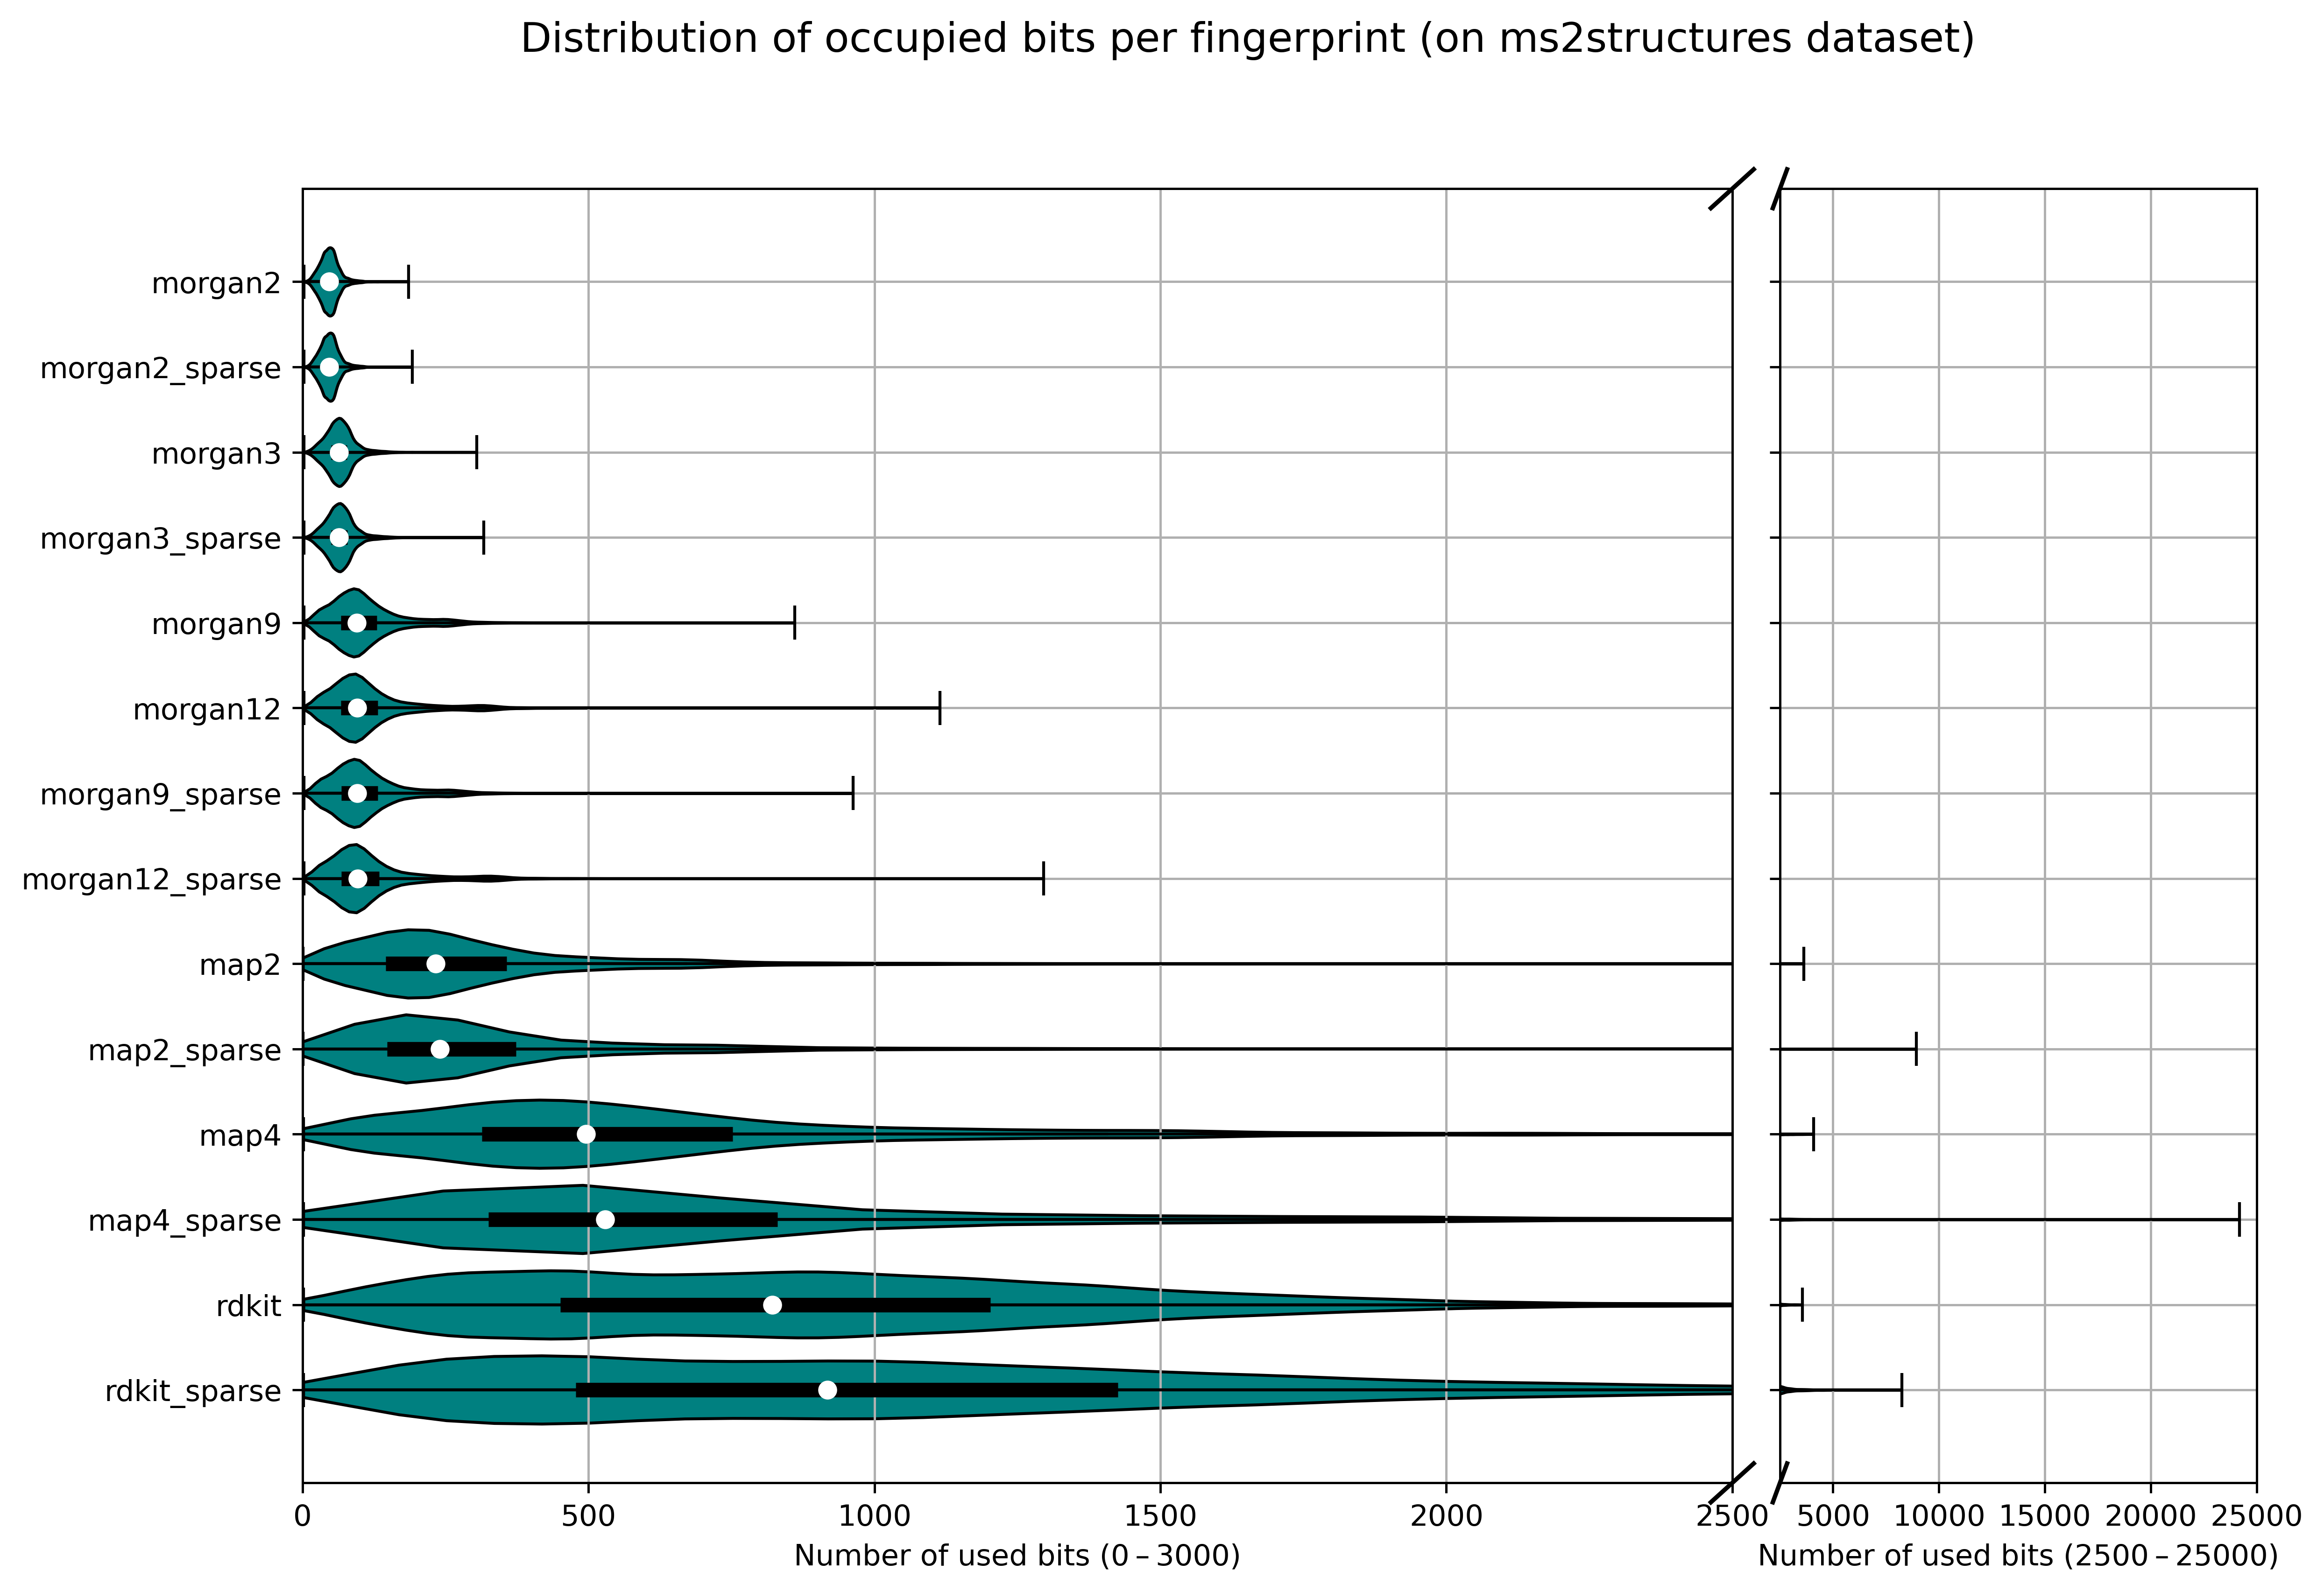

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

# determine the max overall for the right zoom
x_break = 2500
x_max   = 25000

# helper to style a single axis
def style_violin_axis(ax, xlim):
    # plot the violins
    vp = ax.violinplot(
        data_sorted,
        vert=False,
        widths=0.8,
        showmedians=False,
        showextrema=True
    )
    # body color
    for pc in vp['bodies']:
        pc.set_facecolor('teal')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    # extrema lines
    for part in ('cmaxes', 'cmins', 'cbars'):
        lc = vp[part]
        lc.set_color('black')
        lc.set_linewidth(1)
    # custom stems
    inds = np.arange(1, len(labels_sorted) + 1)
    ax.scatter(med_sorted, inds, marker='o', color='white', s=30, zorder=3)
    ax.hlines(inds, q1_sorted, q3_sorted, color='k', linestyle='-', lw=5)
    ax.hlines(inds, wh_min_sorted, wh_max_sorted, color='k', linestyle='-', lw=1)
    # y‐labels only on left axis
    ax.set_yticks(inds)
    ax.set_yticklabels([s.replace("_binary", "") for s in labels_sorted])
    # common styling
    ax.set_xlim(*xlim)
    #ax.invert_yaxis()
    ax.grid(True)

# build figure with two subplots, shared y
fig = plt.figure(figsize=(12, 8), dpi=450)
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1], wspace=0.05)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)
ax1.invert_yaxis()

# Left panel: full violins clipped to [0, x_break]
style_violin_axis(ax1, (0, x_break))
ax1.set_xlabel('Number of used bits (0 – 3000)')

# Right panel: zoom-in [x_break, x_max], hide y-ticks
style_violin_axis(ax2, (x_break, x_max))
ax2.set_xlabel(f'Number of used bits ({x_break} – {int(x_max)})')
plt.setp(ax2.get_yticklabels(), visible=False)

# draw the “break” marks
d = .015  # how big to make the diagonal break marks
# left axis, right side
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d, 1+d), (-d, +d), **kwargs)
ax1.plot((1-d, 1+d), (1-d, 1+d), **kwargs)
# right axis, left side
kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (-d, +d), **kwargs)
ax2.plot((-d, +d), (1-d, 1+d), **kwargs)

fig.suptitle('Distribution of occupied bits per fingerprint (on ms2structures dataset)', fontsize=14)
#plt.tight_layout(rect=[0,0,1,0.95])
plt.savefig("fig_bit_occupation_violin.png", dpi=450)
plt.show()


# Count fingerprint bits

In [131]:
from fingerprint_computation import count_fingerprint_keys

In [141]:
def idf_normalized(df, N):
    def formula(x, N):
        return np.log(N / x)
    max_idf = formula(1, N)
    return formula(df, N) / max_idf

In [135]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096)

fingerprints_morgan3_sparse = compute_fingerprints_from_smiles(
    compounds.smiles, 
    fpgen,
    count=False,
    sparse=True,
    progress_bar=True
)

100%|███████████████████████████████████| 37811/37811 [00:05<00:00, 6595.27it/s]


In [136]:
%%time

unique_keys, counts, first_instances = count_fingerprint_keys(fingerprints_morgan3_sparse)

/home/daisy/Florian/molecular_fingerprint_comparisons/src/fingerprint_computation.py:193: NumbaTypeSafetyWarning: unsafe cast from int64 to int32. Precision may be lost.
  counts[bit] += 1


CPU times: user 1.23 s, sys: 6.14 ms, total: 1.24 s
Wall time: 1.25 s


In [137]:
unique_keys.shape, counts.shape, first_instances.shape

((287577,), (287577,), (287577,))

In [138]:
counts.max(), counts.min()

(np.int32(31788), np.int32(1))

In [142]:
num_compounds = len(fingerprints_morgan3_sparse)

idx = np.where(counts > 1)[0]
bit_weighing = {unique_keys[i]: idf_normalized(counts[i], num_compounds) for i in idx}

In [143]:
pd.DataFrame({
    "bit": unique_keys[idx],
    "count": counts[idx]
}).to_csv("bit_counts_ms2structures_morgan3.csv")

In [144]:
pd.DataFrame({
    "bit": list(bit_weighing.keys()),
    "idf_weighing": list(bit_weighing.values())
}).set_index("bit").to_csv("bit_weighing_ms2structures_morgan3.csv")

In [129]:
def get_substructure_smiles(mol, atom_idx, radius):
    if radius == 0:
        # Create a single-atom submolecule for radius=0
        atom = mol.GetAtomWithIdx(atom_idx)
        submol = Chem.RWMol(Chem.Mol())
        new_idx = submol.AddAtom(atom)
        amap = {atom_idx: new_idx}
        subsmiles = Chem.MolToSmiles(submol)
    else:
        # Get the atom environment for the given radius
        env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atom_idx)
        if not env:
            return None  # Handle cases where no environment is found
        amap = {}
        submol = Chem.PathToSubmol(mol, env, atomMap=amap)
        #display(submol)
        #Chem.Kekulize(submol)
        subsmiles = Chem.MolToSmiles(submol, allBondsExplicit=True, allHsExplicit=True)
        #subsmiles = Chem.MolToSmiles(submol)
    return subsmiles

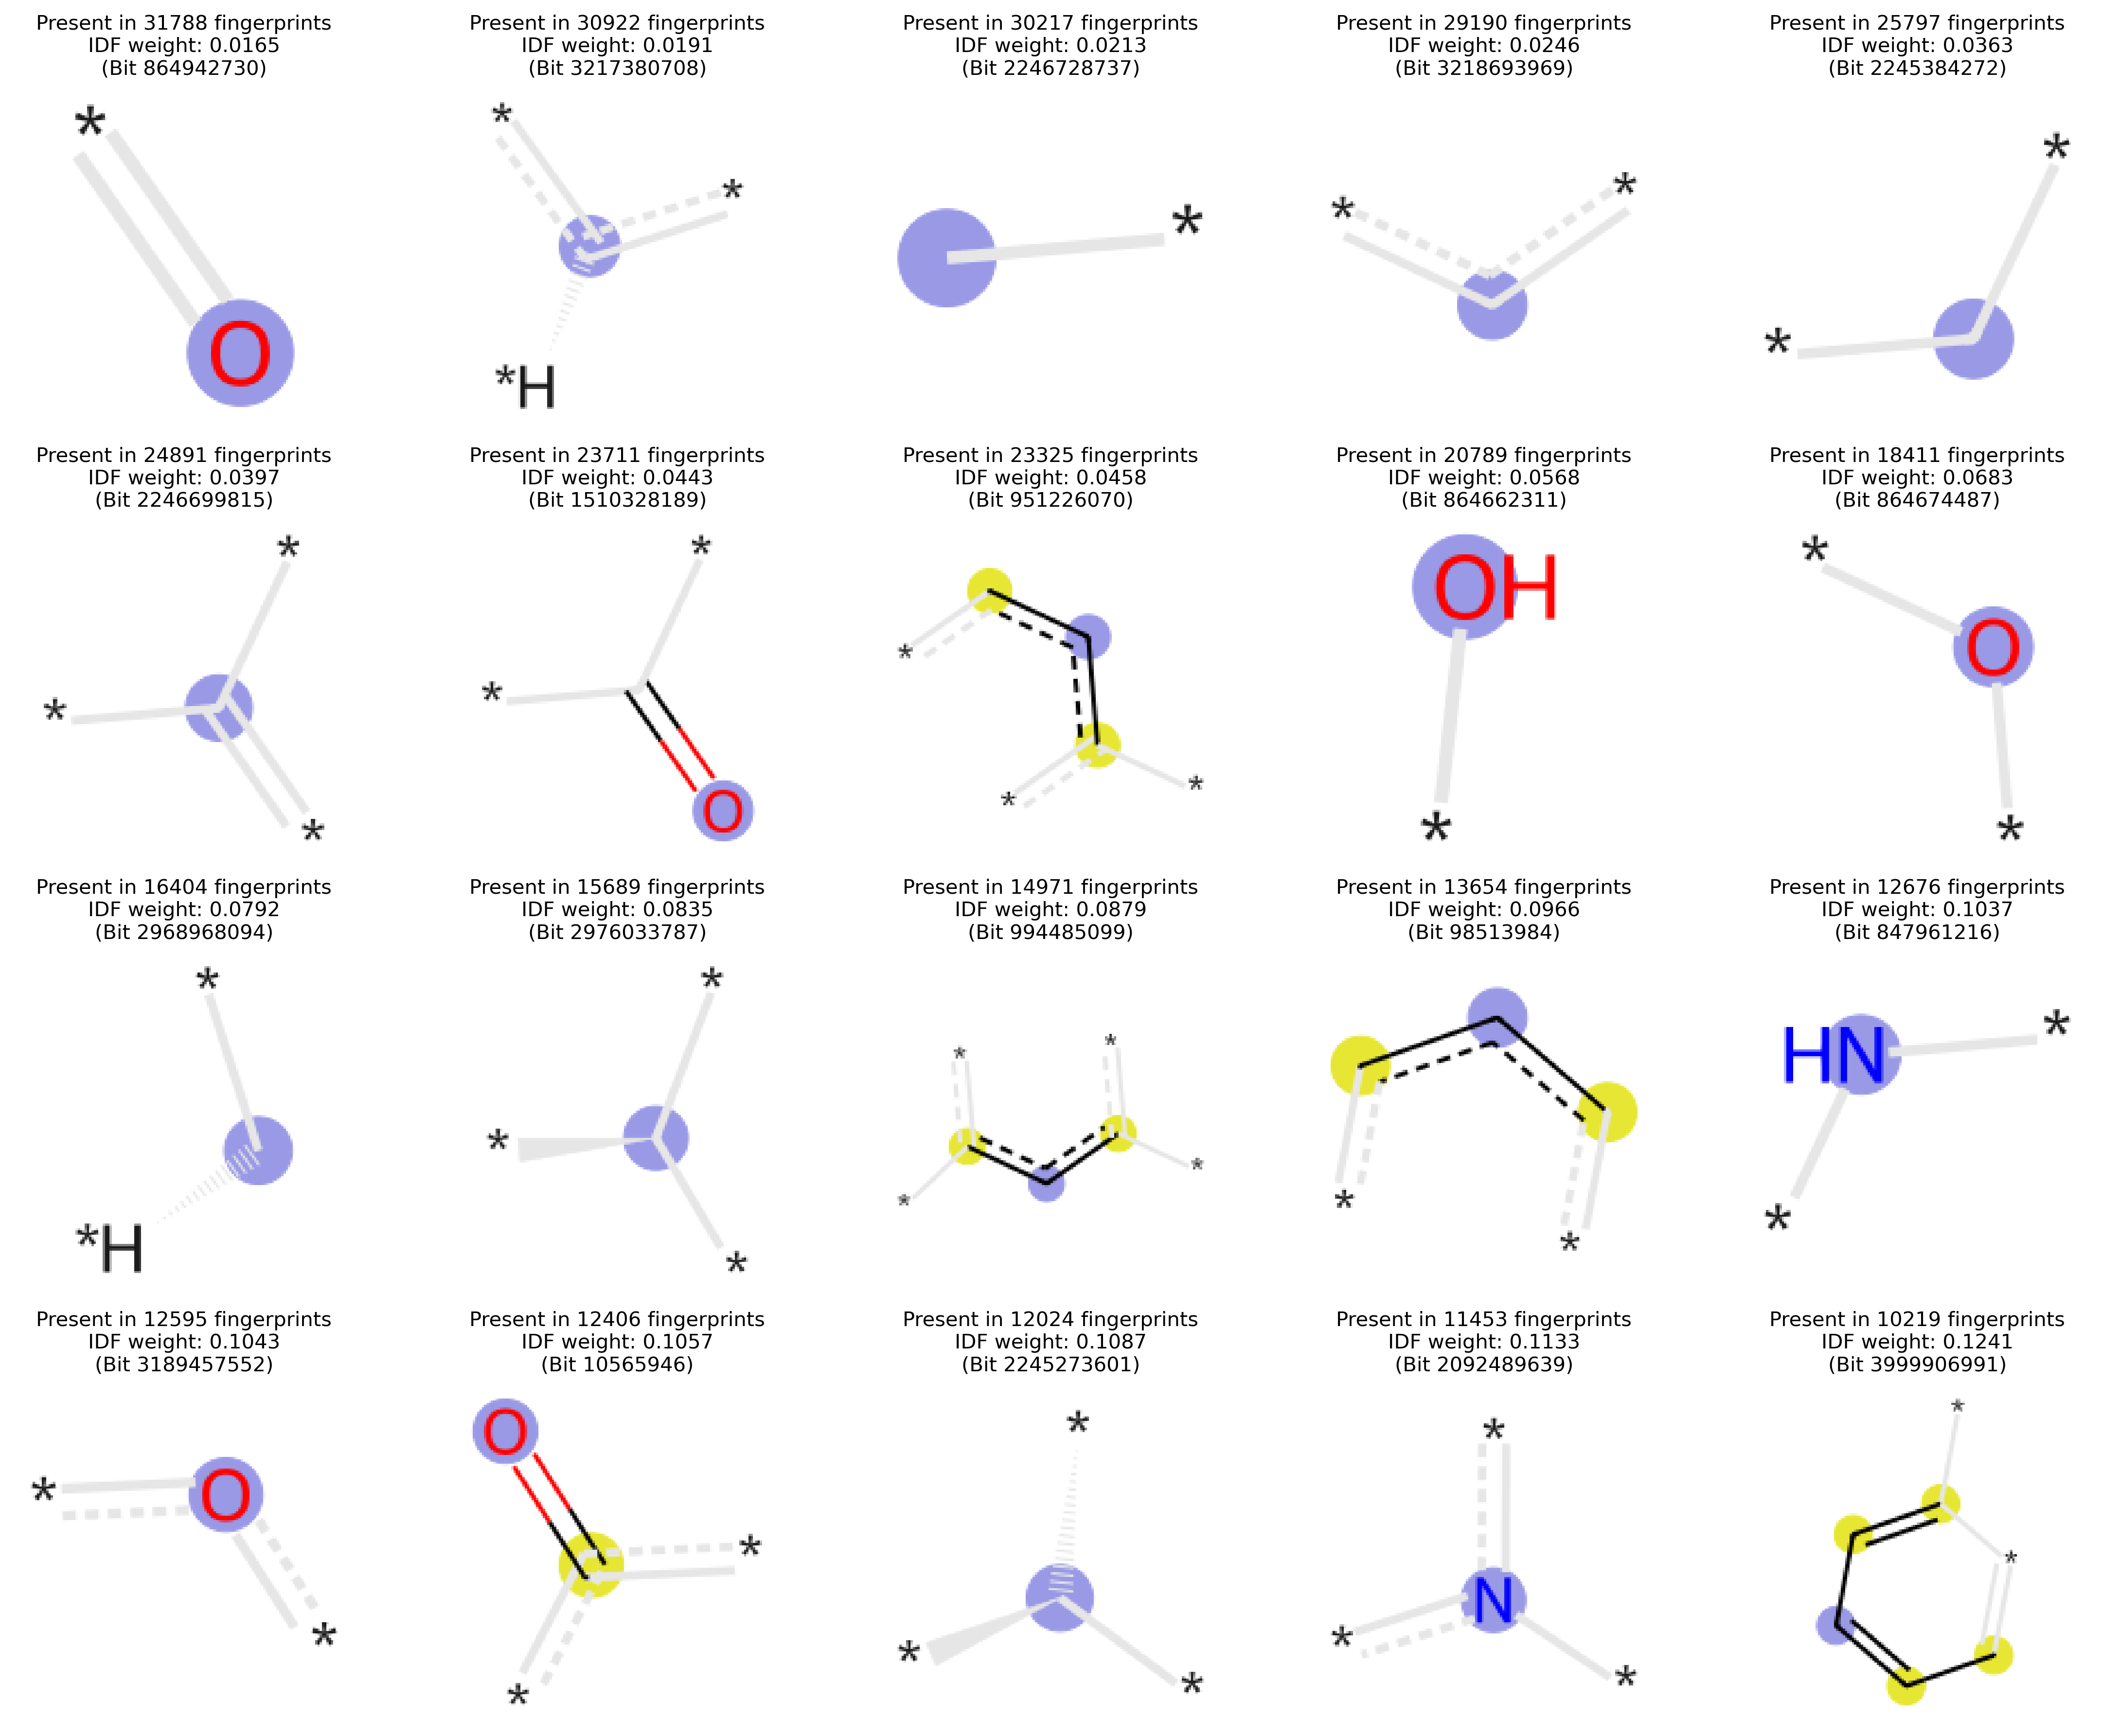

In [ ]:
fpgen = AllChem.GetMorganGenerator(radius=3)

# Initialize data storage for frequent bits
frequent_bits = {
    "counts": [],
    "radius": [],
    "subsmiles": [],
    "bit_id": [],
    "mol_images": [],
}
mol_svgs = []
images = []

idx_sorted = np.argsort(counts)[::-1]


# Process top 20 bits
for i, idx in enumerate(idx_sorted[:20]):
    smiles = compounds.smiles[first_instances[idx]]
    mol = Chem.MolFromSmiles(smiles)

    ao = AllChem.AdditionalOutput()
    ao.CollectBitInfoMap()
    fp = fpgen.GetSparseCountFingerprint(mol, additionalOutput=ao)
    bi = ao.GetBitInfoMap()

    if unique_keys[idx] in bi:
        atom_idx, radius = bi[unique_keys[idx]][0]
        frequent_bits["counts"].append(counts[idx])
        frequent_bits["radius"].append(radius)
        frequent_bits["bit_id"].append(unique_keys[idx])
        
        # Generate substructure SMILES
        if radius == 0:
            subsmiles0 = get_substructure_smiles(mol, atom_idx, 0)
            subsmiles1 = get_substructure_smiles(mol, atom_idx, 1)
            frequent_bits["subsmiles"].append(subsmiles0 + " <-- " + subsmiles1)
        else:
            frequent_bits["subsmiles"].append(get_substructure_smiles(mol, atom_idx, radius))

        # Generate image of molecule with highlighted bit
        img = Draw.DrawMorganBit(mol, unique_keys[idx], bi)#, useSVG=True)
        images.append((mol, unique_keys[idx], bi))
        frequent_bits["mol_images"].append(img)
        #mol_svgs.append(img)

# Convert data to DataFrame
frequent_bits_df = pd.DataFrame(frequent_bits)
frequent_bits_df["idf_weight"] = idf_normalized(frequent_bits_df["counts"], len(fingerprints_morgan3_sparse))

# Create grid plot
n_cols = 5
n_rows = (len(frequent_bits_df) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3), dpi=300)

legends = []

for i, ax in enumerate(axes.flatten()):
    if i < len(frequent_bits_df):
        ax.imshow(frequent_bits_df.loc[i, "mol_images"])
        legend = f"Present in {frequent_bits_df.loc[i, 'counts']} fingerprints\nIDF weight: {frequent_bits_df.loc[i, 'idf_weight']:.4f}\n(Bit {frequent_bits_df.loc[i, 'bit_id']})"
        legends.append(legend)
        ax.set_title(legend, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.savefig("most_frequent_bits_Morgan3.png", dpi=450)
plt.show()